 Análise de Logs

A série temporal é uma coleção de pontos de dados coletados em intervalos de tempo constantes. 





In [1]:
import pandas as pd

dateparse = lambda dates: pd.to_datetime(dates)

df = pd.read_csv('logmes.csv', parse_dates = ['minuto'], index_col = 'minuto', date_parser = dateparse)

In [2]:
df.describe()

,requisicoes,r200,r400,tempo
count,43227.000000,43227.000000,43227.000000,43227.000000
mean,256.063595,211.084739,36.407431,5035.557638
std,207.372229,192.555360,43.289443,4124.732954
min,6.000000,0.000000,0.000000,120.000000
25%,78.000000,45.000000,8.000000,1430.000000
50%,153.000000,120.000000,15.000000,3030.000000
75%,453.000000,326.000000,52.000000,8580.000000
max,676.000000,673.000000,222.000000,13520.000000


In [3]:
df.tail()



,requisicoes,r200,r400,tempo
minuto,,,,
2020-09-30 23:55:20,453,343,62,8580
2020-09-30 23:56:20,88,12,2,1020
2020-09-30 23:57:20,322,224,34,5800
2020-09-30 23:58:20,87,44,12,1430
2020-09-30 23:59:20,345,340,12,6970


Text(0, 0.5, 'Requisições')

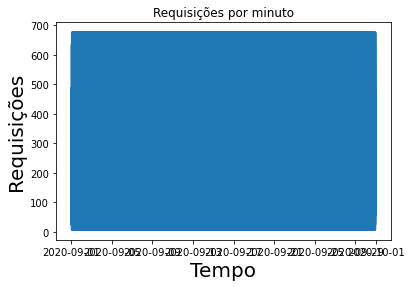

In [4]:
import matplotlib.pylab as plt

ts = df["requisicoes"]

plt.title(label="Requisições por minuto", fontsize=12)
plt.plot(ts)
plt.xlabel("Tempo", fontsize=20)
plt.ylabel("Requisições", fontsize=20)

Text(0, 0.5, 'Requisições')

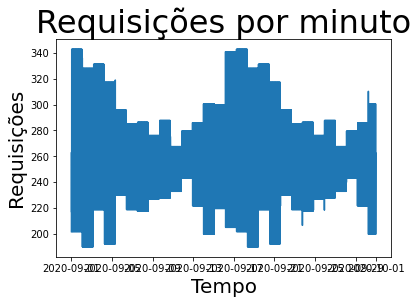

In [5]:
ts_1d = ts.resample('15T', closed='right', label='left').mean()

plt.title(label="Requisições por minuto", fontsize=32)
plt.plot(ts_1d)
plt.xlabel("Tempo", fontsize=20)
plt.ylabel("Requisições", fontsize=20)

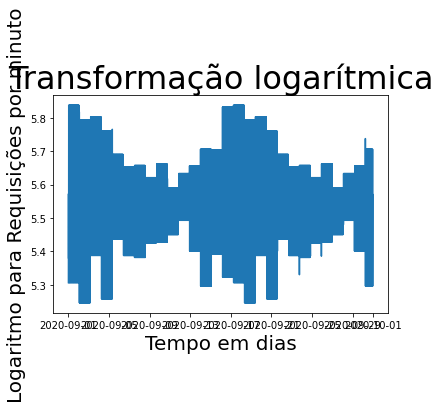

In [6]:
import numpy as np

ts_1d_log = np.log(ts_1d)
#ts_1d_log = np.diff(ts_1d_log)

plt.title("Transformação logarítmica", fontsize=32)
plt.xlabel("Tempo em dias", fontsize=20)
plt.ylabel("Logaritmo para Requisições por minuto", fontsize=20)
plt.plot(ts_1d_log)

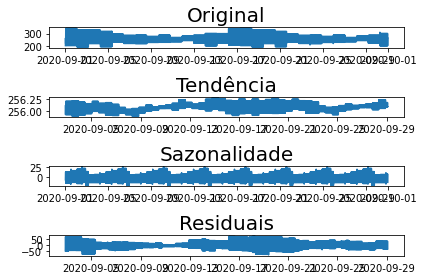

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

def seasonal_decompose_analysis(timeseries, model, periods):
    decomposition = seasonal_decompose(timeseries, model = model, period = periods)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.subplot(411)
    plt.title('Original', fontsize=20)
    plt.plot(timeseries, label='Original')
    plt.subplot(412)
    plt.title('Tendência', fontsize=20)
    plt.plot(trend, label='Tendência')
    plt.subplot(413)
    plt.title('Sazonalidade',fontsize=20)
    plt.plot(seasonal,label='Sazonalidade')
    plt.subplot(414)
    plt.title('Residuais', fontsize=20)
    plt.plot(residual, label='Residuais')
    plt.tight_layout()
    
    return decomposition
    
seasonal_decompose_analysis(ts_1d, 'additive', 365)

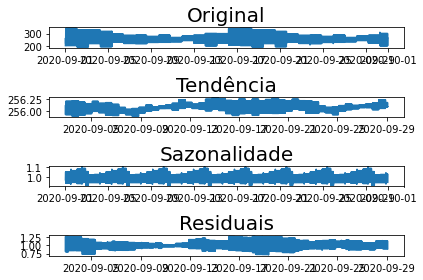

In [8]:
seasonal_decompose_analysis ( ts_1d, 'multiplicativo' , 365)


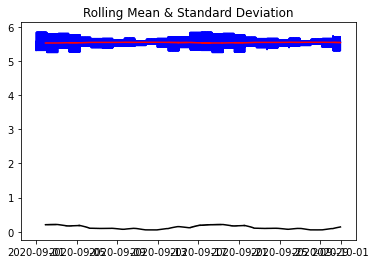

Results of Dickey-Fuller Test
Test Statistic                   -2.429125
p-value                           0.133684
#Lags Used                       17.000000
Number of Observations Used    2862.000000
Critical Value (1%)              -3.432637
Critical Value (5%)              -2.862550
Critical Value (10%)             -2.567308
dtype: float64


In [9]:
from statsmodels.tsa.stattools import adfuller

def stationarity_test(timeseries, rolling_window):
    rolling_mean = timeseries.rolling(rolling_window).mean()
    rolling_std = timeseries.rolling(rolling_window).std()

    orig = plt.plot(timeseries, color='blue', label= 'Original')
    mean = plt.plot(rolling_mean, color='red', label= 'Rolling Mean')
    std = plt.plot(rolling_std, color='black', label = 'Rolling Std')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    # Dickey-Fuller test
    print('Results of Dickey-Fuller Test')
    test = adfuller(timeseries, autolag='AIC')
    output = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
        output['Critical Value (%s)'%key] = value
    print(output)
    
stationarity_test(timeseries = ts_1d_log, rolling_window = 90)

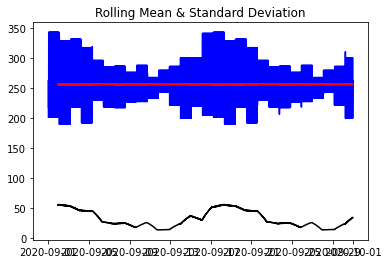

Results of Dickey-Fuller Test
Test Statistic                  -27.092289
p-value                           0.000000
#Lags Used                        6.000000
Number of Observations Used    2873.000000
Critical Value (1%)              -3.432628
Critical Value (5%)              -2.862547
Critical Value (10%)             -2.567306
dtype: float64


In [10]:
stationarity_test ( timeseries  =  ts_1d . dropna (), rolling_window  =  90 )

In [11]:
t_ratio = 0.95
t_size = int(len(ts_1d_log) * t_ratio)

train_1d_log, test_1d_log = ts_1d_log[:t_size].asfreq('30T'), ts_1d_log[t_size:].asfreq('30T')

print("Quantidade de registros da base =", len(ts_1d_log))
print("Quantidade de registros de treinamento =", len(train_1d_log))
print("Quantidade de registros de teste     =", len(test_1d_log))

Original Data Length = 2880
Training Data Length = 1368
Test Data Length     = 72


In [12]:
train_1d_log

minuto
2020-09-01 00:00:00    5.306286
2020-09-01 00:30:00    5.378360
2020-09-01 01:00:00    5.306286
2020-09-01 01:30:00    5.378360
2020-09-01 02:00:00    5.306286
                         ...   
2020-09-29 09:30:00    5.400874
2020-09-29 10:00:00    5.538646
2020-09-29 10:30:00    5.400874
2020-09-29 11:00:00    5.538646
2020-09-29 11:30:00    5.400874
Freq: 30T, Name: requisicoes, Length: 1368, dtype: float64

In [13]:
train_1d_log.describe()

count    1368.000000
mean        5.551657
std         0.134826
min         5.245620
25%         5.450180
50%         5.563498
75%         5.633122
max         5.837730
Name: requisicoes, dtype: float64

In [14]:
import statsmodels.api as sm

sarima_model = sm.tsa.statespace.SARIMAX(train_1d_log,
                            order=(2, 1, 4),
                            seasonal_order=(0, 1, 0, 5),
                            enforce_invertibility=False,
                            enforce_stationarity=False)

result_sarima = sarima_model.fit()

print('SARIMA - AIC : {}'.format(result_sarima.aic))

# SARIMA - AIC : -296.90534927970805


SARIMA - AIC : -7132.211465268898


/home/mferste/.local/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [15]:
ts.tail()

minuto
2020-09-30 23:55:20    453
2020-09-30 23:56:20     88
2020-09-30 23:57:20    322
2020-09-30 23:58:20     87
2020-09-30 23:59:20    345
Name: requisicoes, dtype: int64

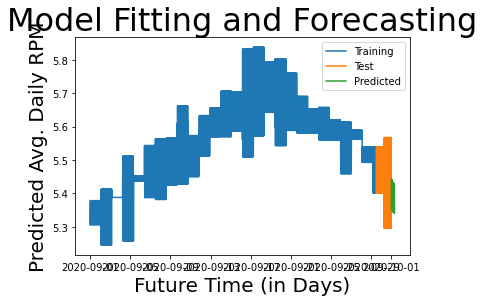

In [16]:
pred_sarima = result_sarima.predict(start=0, end=8000)

plt.title('Treinamento e previsão', fontsize=32)
plt.xlabel('Tempo futuro em dias', fontsize=20)
plt.ylabel('Predição diária em requisição por minuto', fontsize=20)

plt.plot(train_1d_log, label='Treinamento')
plt.legend(loc='best')
           
plt.plot(test_1d_log, label='Teste')
plt.legend(loc='best')

plt.plot(pred_sarima['2020-09-30 23:59:20':'2020-10-01 07:59:20'], label='Predicted')
plt.legend(loc='best')